In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split, GridSearchCV
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
sns.set()
pd.set_option('display.max_columns', None)

In [2]:
df_tr = pd.read_csv('titanic/train.csv')
df_te = pd.read_csv('titanic/test.csv')
display(df_tr.head(), df_te.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
print('Train null values')
print(df_tr.isnull().sum())
print('-----------------------------')
print('Test null values')
print(df_te.isnull().sum())

Train null values
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
-----------------------------
Test null values
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [4]:
# combine the train and test set to see the data distribution
df = df_tr.append(df_te).reset_index(drop=True)
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [5]:
df_tr.describe(include='all')
# we can find some duplicate in Age, Ticket attribute

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Meanwell, Miss. (Marion Ogden)",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


# Exporatory Data Analysis(EDA)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


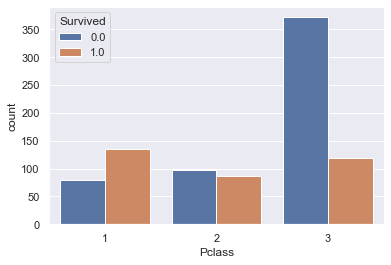

In [7]:
# pclass
sns.countplot(x=df.Pclass, hue=df)
display(df_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())
# better plcass make it more likely to survive

,Sex,Survived
0,female,0.742038
1,male,0.188908


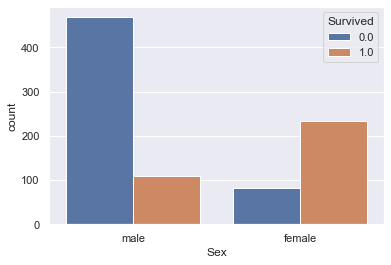

In [6]:
# Sex
sns.countplot(x=df_data['Sex'], hue=df_data['Survived'])
display(df_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean())
# observattion from the plot: female is more easier survive than male

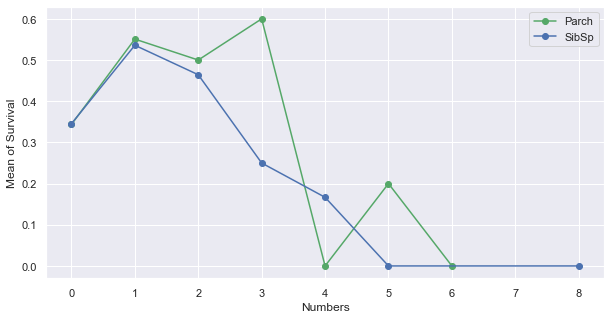

In [8]:
# Parch and Sibsp
df_parch = df_data[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean()
df_sibsp = df_data[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean()

fig = plt.figure(figsize=(10, 5))
ax = plt.gca()
ax.plot(df_parch['Parch'], df_parch['Survived'], '-og', label='Parch')
ax.plot(df_sibsp['SibSp'], df_sibsp['Survived'], '-ob', label='SibSp')
ax.set_xlabel('Numbers')
ax.set_ylabel('Mean of Survival')
ax.legend()
plt.show()

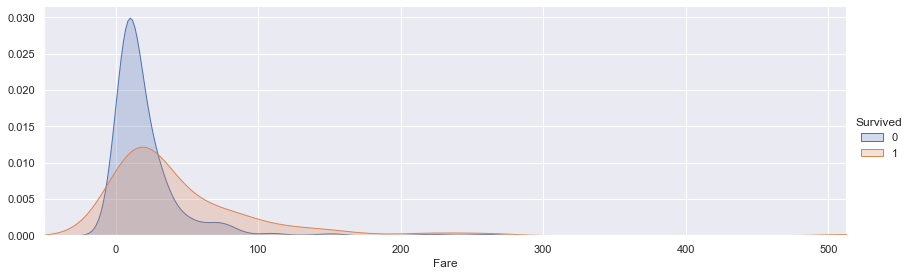

In [9]:
# Fare
df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())

fg = sns.FacetGrid(df_tr, hue="Survived",aspect=3, height=4)
fg.map(sns.kdeplot, 'Fare', shade=True)
fg.set(xlim=(-50, df_tr['Fare'].max()))
fg.add_legend()
plt.show()
# fare gas some outliers
# higher fare has higher survival rate
# shall consider fare but need to bucket

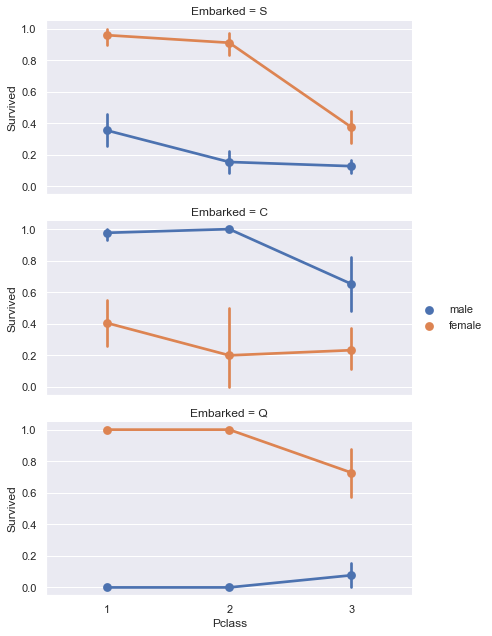

In [10]:
# embarked
fg = sns.FacetGrid(df_data, row='Embarked', height=3, aspect=2)
fg.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', hue_order=None, order=[1, 2, 3])
fg.add_legend()
plt.show()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


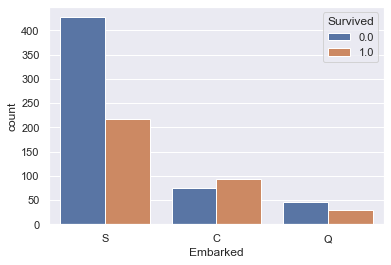

In [11]:
sns.countplot(x=df_data['Embarked'], hue=df_data['Survived'])
display(df_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())
# male has higher survival rate than females at port C
# highest survival rate at C and lowest survival rate at S
# most passenger embarked at port S
# the feature Embarked should be completed and we shall consider Embarked

# Feature Engineering and Data cleaning

In [12]:
# Encoding sex feature
df_data['Sex#'] = df_data['Sex'].map({'male': 0, 'female': 1})

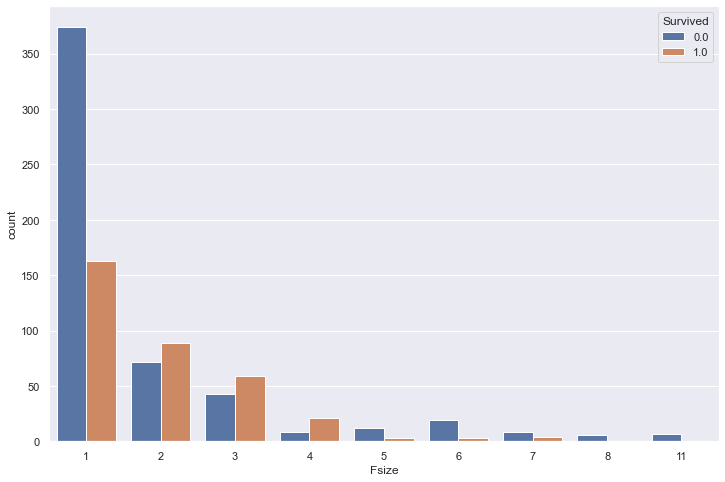

In [13]:
# family size
df_data['Fsize'] = df_data['Parch'] + df_data['SibSp'] + 1
fg = plt.figure(figsize=(12, 8))
sns.countplot(x=df_data['Fsize'], hue=df_data['Survived'])
legend = plt.legend(title='Survived', loc='upper right')
plt.show()

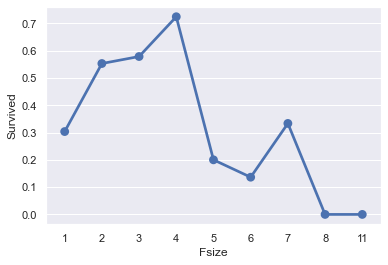

In [14]:
sns.pointplot(x='Fsize', y='Survived', data=df_data[['Fsize', 'Survived']].groupby(['Fsize'], as_index=False).mean())
plt.show()
# small family size has higher survived rate

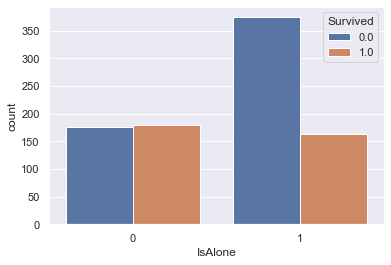

In [15]:
# is alone alternatively
# Create new feature
df_data['IsAlone']  = 0
df_data.loc[df_data.Fsize == 1, 'IsAlone'] = 1

# Plot
sns.countplot(x=df_data['IsAlone'], hue=df_data['Survived'])
plt.show()

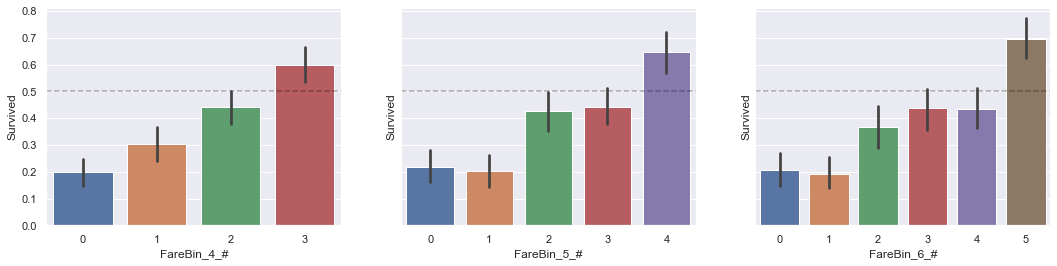

In [16]:
# Making bins
df_data['FareBin_4'] = pd.qcut(df_data['Fare'], 4)
df_data['FareBin_5'] = pd.qcut(df_data['Fare'], 5)
df_data['FareBin_6'] = pd.qcut(df_data['Fare'], 6)

# Mapping the bins
label_encoder = LabelEncoder()
df_data['FareBin_4_#'] = label_encoder.fit_transform(df_data['FareBin_4'])
df_data['FareBin_5_#'] = label_encoder.fit_transform(df_data['FareBin_5'])
df_data['FareBin_6_#'] = label_encoder.fit_transform(df_data['FareBin_6'])

# Plot
fig, [ax1, ax2, ax3] = plt.subplots(1, 3,sharey=True)
fig.set_figwidth(18)
for axi in [ax1, ax2, ax3]:
    axi.axhline(0.5, linestyle='dashed', c='black', alpha = .3)
g1 = sns.barplot(x='FareBin_4_#', y="Survived", data=df_data, ax=ax1)
g2 = sns.barplot(x='FareBin_5_#', y="Survived", data=df_data, ax=ax2)
g3 = sns.barplot(x='FareBin_6_#', y="Survived", data=df_data, ax=ax3)

In [17]:
# splits again beacuse we just engineered new feature
df_train = df_data[:len(df_tr)]
df_test = df_data[len(df_te):]

# Training set and labels
x_train = df_train.drop(labels=['Survived','PassengerId'], axis=1)
y_train = df_train['Survived']

# show columns
x_train.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Sex#', 'Fsize', 'IsAlone', 'FareBin_4',
       'FareBin_5', 'FareBin_6', 'FareBin_4_#', 'FareBin_5_#', 'FareBin_6_#'],
      dtype='object')

In [18]:
# 
compare_features = ['Sex#','Pclass','FareBin_4_#','FareBin_5_#','FareBin_6_#']
estimator = RandomForestClassifier(n_estimators=250, min_samples_split=20)
selector = RFECV(estimator, cv=10, n_jobs=-1) # cv=10 means using 10-fold cross validation, n_jobs=-1 means using all processors
selector.fit(x_train[compare_features], y_train)

print('The mask of selected features: ', selector.support_) # The mask of selected features.
print('Feature rankings: ', selector.ranking_) # The feature ranking, such that ranking[i] corresponds to the ranking position of the i-th feature. 
print('CV scores: ', selector.grid_scores_*100) # The cross-validation scores such that grid_scores[i] corresponds to the CV score of the i-th subset of features.

The mask of selected features:  [ True  True  True  True  True]
Feature rankings:  [1 1 1 1 1]
CV scores:  [78.67290886 77.44444444 79.3545568  79.24344569 80.70037453]


In [19]:
score_b4,score_b5, score_b6 = [], [], []
seeds = 10

for i in range(seeds):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
    estimator = RandomForestClassifier(random_state=i, n_estimators=250, min_samples_split=20)
    selector = RFECV(estimator=estimator, cv=cv, n_jobs=-1)
    selector.fit(x_train[compare_features], y_train)
    
    score_b4.append(selector.grid_scores_[2])
    score_b5.append(selector.grid_scores_[3])
    score_b6.append(selector.grid_scores_[4])


# class sklearn.model_selection.StratifiedKFold(n_splits=5, *, shuffle=False, random_state=None)

# Parameters:

# n_splitsint: default=5
# Number of folds, like the k-value in K-fold. Must be at least 2.

# shufflebool: default=False
# Whether to shuffle each class’s samples before splitting into batches. Note that the samples within each split will not be shuffled.

# random_state: RandomState instance or None, default=None
# When shuffle is True, random_state affects the ordering of the indices, which controls the randomness of each fold for each class. Otherwise, leave random_state as None.

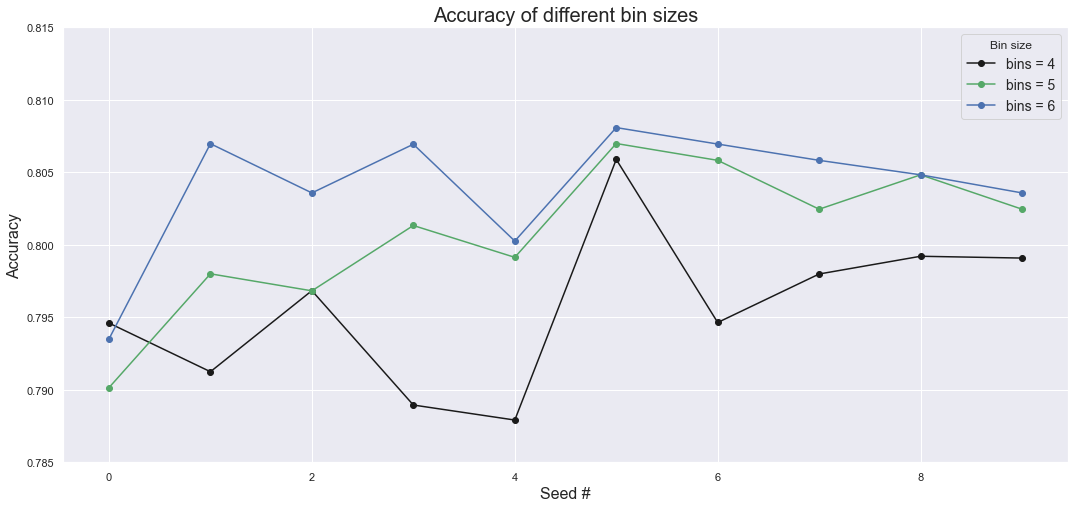

In [20]:
# to np.array
score_list = [score_b4, score_b5, score_b6]
for item in score_list:
    item = np.array(item*100)

# plot
fig = plt.figure(figsize= (18,8))
ax = plt.gca()
ax.plot(range(seeds), score_b4,'-ok',label='bins = 4')
ax.plot(range(seeds), score_b5,'-og',label='bins = 5')
ax.plot(range(seeds), score_b6,'-ob',label='bins = 6')
ax.set_xlabel('Seed #', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_ylim(0.785, 0.815)
ax.set_title('Accuracy of different bin sizes', fontsize=20)
plt.legend(fontsize=14, loc='upper right', title='Bin size')
plt.show()
#Bin size = 6 gets better accuracy at most of the time.
#Bin size = 5 works better in Seed 5.
#Bin size = 4 only gets the best accuracy in Seed 0 and performs lowest accuracy at most of the time.
#The graph indicates that bin size = 6 is the best choice.

In [21]:
b4, b5, b6 = ['Sex#', 'Pclass','FareBin_4_#'], ['Sex#','Pclass','FareBin_5_#'], ['Sex#','Pclass','FareBin_6_#']

# Train models and predict
b4_Model = RandomForestClassifier(
    random_state=2, 
    n_estimators=250, 
    min_samples_split=20, 
    oob_score=True)
b4_Model.fit(x_train[b4], y_train)

b5_Model = RandomForestClassifier(
    random_state=2, 
    n_estimators=250, 
    min_samples_split=20, 
    oob_score=True)
b5_Model.fit(x_train[b5], y_train)

b6_Model = RandomForestClassifier(
    random_state=2, 
    n_estimators=250, 
    min_samples_split=20, 
    oob_score=True)
b6_Model.fit(x_train[b6], y_train)

# Show oob scores
print('Bin size = 4, oob score :{:3f}'.format(b4_Model.oob_score_))
print('Bin size = 5, oob score :{:3f}'.format(b5_Model.oob_score_))
print('Bin size = 6, oob score :{:3f}'.format(b6_Model.oob_score_))

Bin size = 4, oob score :0.805836
Bin size = 5, oob score :0.810325
Bin size = 6, oob score :0.801347


In [22]:
# Drop features we created in the process exclude FareBin_5_# which is what we need
df_data['FareBin'] = df_data['FareBin_5_#']
df_data = df_data.drop(['FareBin_4', 'FareBin_5', 'FareBin_6', 'FareBin_4_#', 'FareBin_5_#', 'FareBin_6_#'], axis=1)

In [23]:
# family name
df_data['Fname'] = df_data['Name'].str.extract('([A-Za-z]+.[A-Za-z]+)\,', expand=True)
df_data['Fname']

0          Braund
1         Cumings
2       Heikkinen
3        Futrelle
4           Allen
          ...    
1304      Spector
1305      y Ocana
1306      Saether
1307         Ware
1308        Peter
Name: Fname, Length: 1309, dtype: object

In [24]:
# We can assume that passengers with same Ticket are friends or families.
duplicates = []

for uniq in df_data['Ticket'].unique():
    temp = df_data.loc[df_data['Ticket'] == uniq, 'Name']
    if temp.count() > 1:
        duplicates.append(df_data.loc[df_data['Ticket'] == uniq, ['Name', 'Ticket', 'Fare', 'FareBin', 'Fsize', 'Survived']])
duplicates = pd.concat(duplicates)
duplicates.head(20)

,Name,Ticket,Fare,FareBin,Fsize,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,4,2,1.0
1125,"Cumings, Mr. John Bradley",PC 17599,71.2833,4,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,4,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,4,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,4,1,0.0
1037,"Hilliard, Mr. Herbert Henry",17463,51.8625,4,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,2,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,2,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,2,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,2,5,0.0


In [25]:
df_friend = duplicates.loc[(duplicates.Fsize == 1) & (duplicates.Survived.notnull())]
df_family = duplicates.loc[(duplicates.Fsize > 1) & (duplicates.Survived.notnull())]
display(df_friend.head(), df_family.head())

,Name,Ticket,Fare,FareBin,Fsize,Survived
6,"McCarthy, Mr. Timothy J",17463,51.8625,4,1,0.0
20,"Fynney, Mr. Joseph J",239865,26.0000,3,1,0.0
791,"Gaskell, Mr. Alfred",239865,26.0000,3,1,0.0
195,"Lurette, Miss. Elise",PC 17569,146.5208,4,1,1.0
681,"Hassab, Mr. Hammad",PC 17572,76.7292,4,1,1.0


,Name,Ticket,Fare,FareBin,Fsize,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,4,2,1.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,4,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,4,2,0.0
7,"Palsson, Master. Gosta Leonard",349909,21.0750,2,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,2,5,0.0


In [26]:
print('Passengers taking the same ticket: ', duplicates['Name'].count())
print('Family: ', df_family['Name'].count())
print('Friend: ', df_friend['Name'].count())
print('Other: ', duplicates['Name'].count() - df_family['Name'].count() - df_friend['Name'].count())

Passengers taking the same ticket:  596
Family:  321
Friend:  89
Other:  186


In [27]:
df_data['Connected_Survival'] = 0.5

for ticket_num, df_grp in df_data.groupby('Ticket'):
    if len(df_grp) > 1: # We just want the data with duplicated tickets
            for index, row in df_grp.iterrows():
                smax = df_grp.drop(index).Survived.max()
                smin = df_grp.drop(index).Survived.min()
                pid = row.PassengerId
                if smax == 1.0:
                    df_data.loc[df_data['PassengerId'] == pid, 'Connected_Survival'] = 1
                elif smin == 0.0:
                    df_data.loc[df_data['PassengerId'] == pid, 'Connected_Survival'] = 0

In [28]:
# Filling missing Embarked
df_data[df_data['Embarked'].isnull()][['Embarked', 'Pclass', 'FareBin']]
# check the relation
df_data.groupby(['Embarked', 'Pclass'])[['FareBin']].median()
# seems not have strong connection 

FareBin
Embarked Pclass         
C        1             4
         2             2
         3             1
Q        1             4
         2             2
         3             0
S        1             4
         2             2
         3             1

In [29]:
# Take a look at the missing values. Using Fare instead of FareBin
print(df_data[df_data['Embarked'].isnull()][['Embarked', 'Pclass', 'Fare']])
# check the relation
df_data.groupby(['Embarked', 'Pclass'])[['Fare']].median()
# C,1 (76.73, 1) value is close to (80,1)m full null with value C

    Embarked  Pclass  Fare
61       NaN       1  80.0
829      NaN       1  80.0


Fare
Embarked Pclass         
C        1       76.7292
         2       15.3146
         3        7.8958
Q        1       90.0000
         2       12.3500
         3        7.7500
S        1       52.0000
         2       15.3750
         3        8.0500

In [30]:
# Filling missing values with the value that has greatest frequency
df_data['Embarked'] = df_data['Embarked'].fillna('C')

# Mapping
df_data['Embarked#'] = df_data['Embarked'].map({'S': 1, 'C': 2, 'Q': 3})
df_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex#,Fsize,IsAlone,FareBin,Fname,Connected_Survival,Embarked#
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,2,0,0,Braund,0.5,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,2,0,4,Cumings,0.5,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,1,1,Heikkinen,0.5,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,2,0,4,Futrelle,0.0,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,1,1,Allen,0.5,1


In [31]:
# extract title from Name
df_data['Title'] = df_data['Name'].str.extract('([A-Za-z]+)\.', expand=False)
df_data['Title'] = df_data['Title'].replace(['Capt', 'Col', 'Rev', 'Don', 'Countess', 'Jonkheer', 'Dona', 'Sir', 'Dr', 'Major', 'Dr'], 'Rare')
df_data['Title'] = df_data['Title'].replace(['Mlle', 'Mme', 'Ms'], 'Miss')
df_data['Title'] = df_data['Title'].replace(['Lady'], 'Mrs')
df_data['Title'] = df_data['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })
df_data['Title']

0       0
1       4
2       3
3       4
4       0
       ..
1304    0
1305    1
1306    0
1307    0
1308    2
Name: Title, Length: 1309, dtype: int64

In [34]:
# age
df_data.Age.describe()


# There are 177 and 86 missing values of Age in trainin data and testing data. Since we assume that Age is an important factor to Survived, we need to fill in the null 
# values. It seems that several methods can help us to obtain (or guess) the values:

# Just use the median or mean of Age to fill in all the null values.
# Find existing features that are highly correlated with Age and proceed prediction to get the value. Here I will try five approches to do this. (maybe there is no need to do some of them?)
# Guess Age values using median values for Age across sets of feature combinations (manual way).
# Guess Age values using the Title of the passengers.
# Predict Age values with linear regression model.
# Filling null values with KNN imputer.
# Predict Age values with keras model (Deep Learning).


count    1046.000000
mean       29.900574
std        14.409117
min         1.000000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

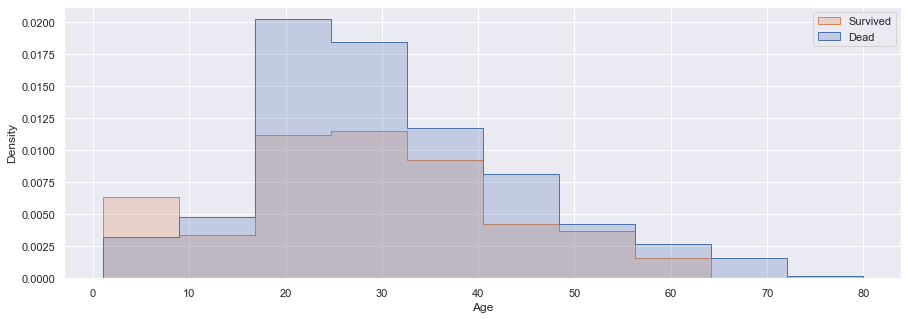

In [33]:
df_data.loc[df_data.Age.notnull(), 'Age'] = df_data.loc[df_data.Age.notnull(), 'Age'].apply(np.ceil).astype('int')
df_age = df_data.loc[(df_data.Age.notnull() & df_data.Survived.notnull())]

fg, ax = plt.subplots(figsize=(15, 5))
ax = sns.histplot(df_age, x='Age', hue='Survived', kde=False, bins=10, palette='deep', label='Survived', element='step', stat='density')
ax.legend(['Survived', 'Dead'])
plt.show()
# high dead rate between 20 to 30 year old
# high survive rate under 15 year old

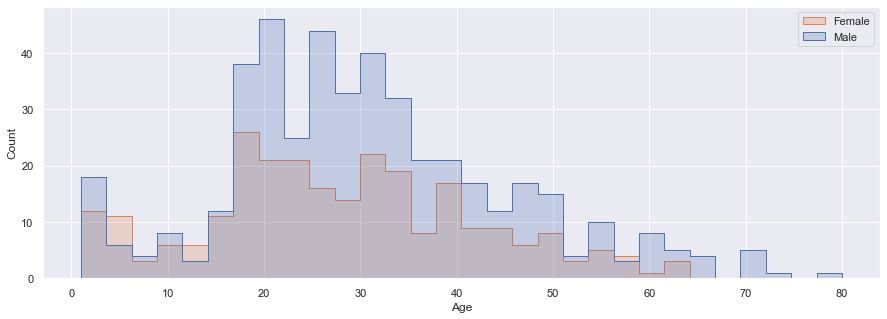

In [37]:
df_sex = df_data.loc[df_data.Age.notnull()]

fg, ax = plt.subplots(figsize=(15, 5))
ax = sns.histplot(df_age, x='Age', hue='Sex', kde=False, bins=30, palette='deep', label='Sex', element='step')
ax.legend(['Female', 'Male'])
plt.show()

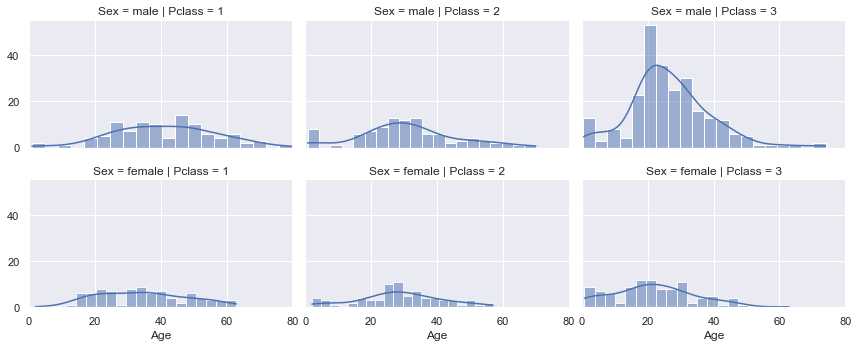

In [38]:
grid = sns.FacetGrid(df_train, row='Sex', col='Pclass', height=2.5, aspect=1.6)
grid.map(sns.histplot, 'Age',kde=True, alpha=.5, bins=20)
grid.set(xlim=(0, 80), ylim=(0, 55))
plt.show()

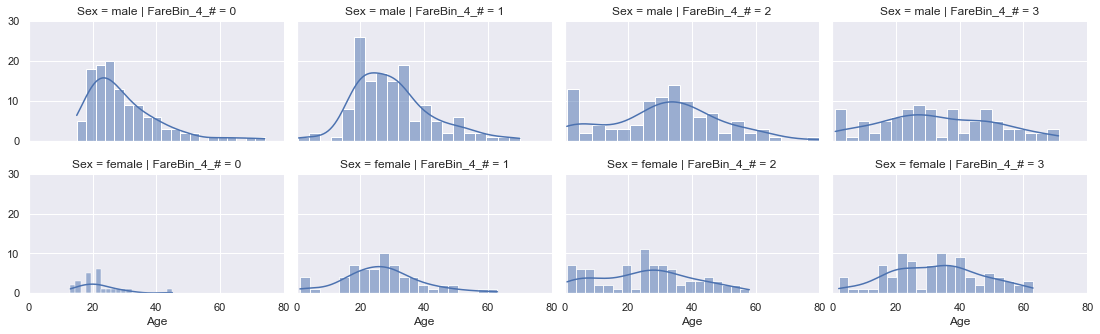

In [39]:
grid = sns.FacetGrid(df_train, row='Sex', col='FareBin_4_#', height=2.4, aspect=1.6)
grid.map(sns.histplot, 'Age',kde=True, alpha=.5, bins=20)
grid.set(xlim=(0, 80), ylim=(0, 30))
plt.show()

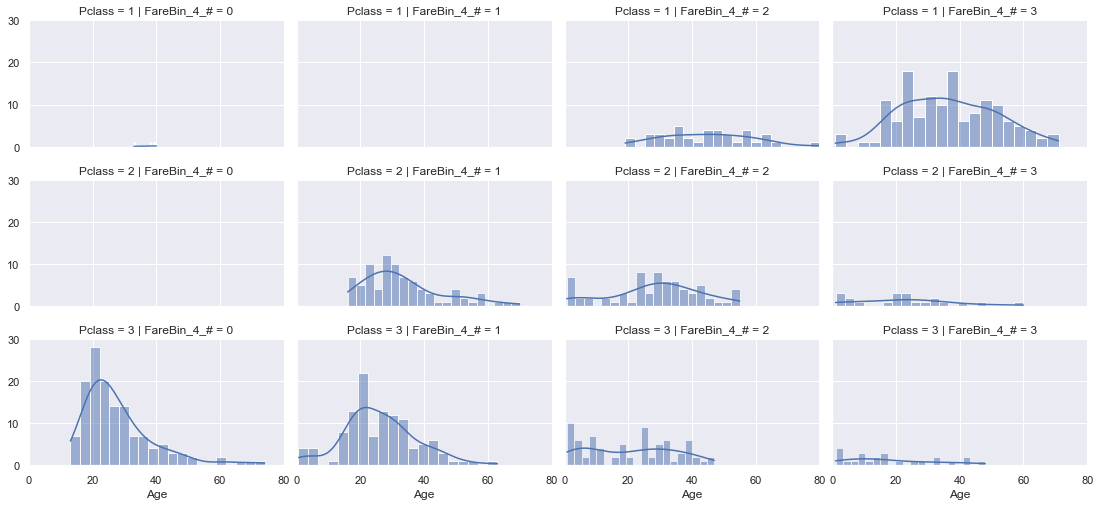

In [40]:
grid = sns.FacetGrid(df_train, row='Pclass', col='FareBin_4_#', height=2.4, aspect=1.6)
grid.map(sns.histplot, 'Age',kde=True, alpha=.5, bins=20)
grid.set(xlim=(0, 80), ylim=(0, 30))
plt.show()

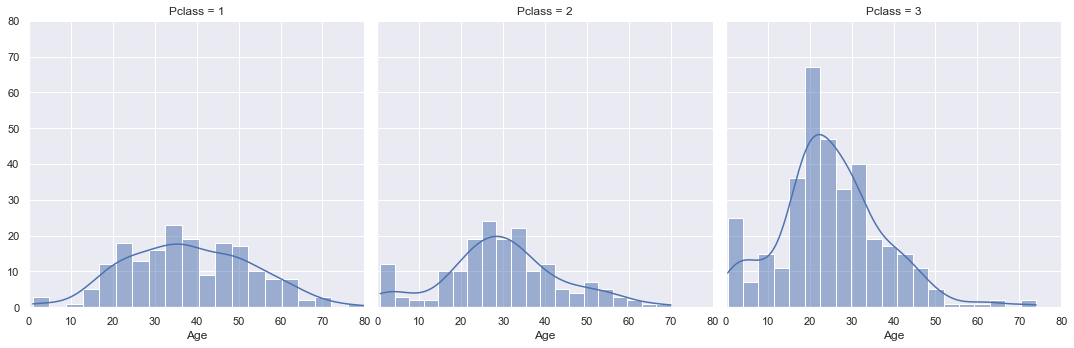

In [41]:
grid = sns.FacetGrid(df_train, col='Pclass', height=5, aspect=1)
grid.map(sns.histplot, 'Age',kde=True, alpha=.5, bins=20)
grid.set(xlim=(0, 80), ylim=(0, 80))
plt.show()

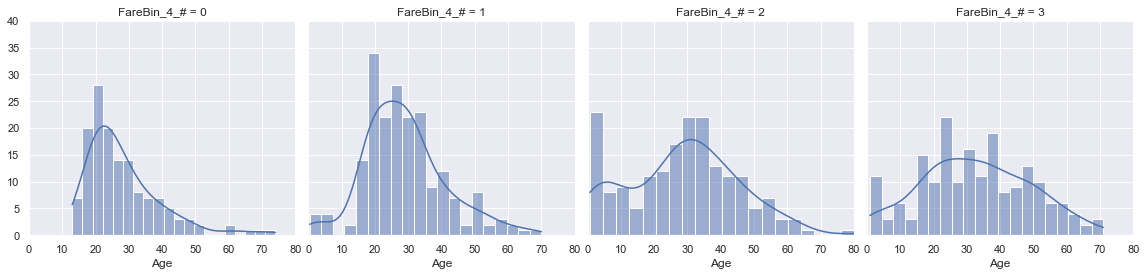

In [42]:
grid = sns.FacetGrid(df_train, col='FareBin_4_#', height=4, aspect=1)
grid.map(sns.histplot, 'Age',kde=True, alpha=.5, bins=20)
grid.set(xlim=(0, 80), ylim=(0, 40))
plt.show()

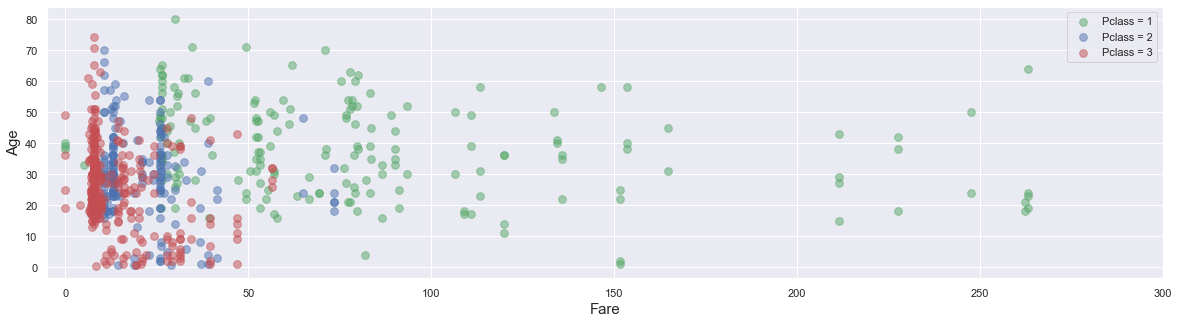

In [43]:
class_1 = df_train[df_train['Pclass']==1]
class_2 = df_train[df_train['Pclass']==2]
class_3 = df_train[df_train['Pclass']==3]

color = ['g', 'b', 'r']
alpha = 0.5
scale = 60.

plt.figure(figsize=(20, 5))
scatter = plt.scatter(class_1['Fare'], class_1['Age'], label='Pclass = 1', c=color[0], alpha=alpha, s=scale)
scatter = plt.scatter(class_2['Fare'], class_2['Age'], label='Pclass = 2', c=color[1], alpha=alpha, s=scale)
scatter = plt.scatter(class_3['Fare'], class_3['Age'], label='Pclass = 3', c=color[2], alpha=alpha, s=scale)
plt.xlabel('Fare', fontsize=15)
plt.ylabel('Age', fontsize=15)
plt.xlim(-5, 300)
plt.legend()
plt.show()


In [44]:
# method 1 Guess age median with Pclass and Sex
df_data['Age_pred1'] = df_data['Age']
guess_ages = np.zeros((2, 3))

for sex in range(0, 2):
    for pclass in range(0, 3):
        guess_df = df_data[(df_data['Sex#'] == sex) & (df_data['Pclass'] == pclass + 1)]['Age_pred1'].dropna()
        age_guess = guess_df.median()

        # Convert random age float to nearest .5 age
        guess_ages[sex, pclass] = int(age_guess/0.5 + 0.5) * 0.5
            
for sex in range(0, 2):
    for pclass in range(0, 3):
        df_data.loc[(df_data['Age_pred1'].isnull()) & (df_data['Sex#'] == sex) & (df_data.Pclass == pclass + 1), 'Age_pred1'] = guess_ages[sex,pclass]

df_data['Age_pred1'] = df_data['Age_pred1'].astype(int)

# Check our prediction correctly saved in df
df_data.loc[df_data.Age.isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex#,Fsize,IsAlone,FareBin,Fname,Connected_Survival,Embarked#,Title,Age_pred1
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,1,1,1,Moran,0.5,3,0,25
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,0,1,1,2,Williams,0.5,1,0,29
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,1,1,1,0,Masselmani,0.5,2,4,22
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,0,1,1,0,Emir,0.5,2,0,25
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,1,1,1,1,O'Dwyer,0.5,3,3,22


In [45]:
# Method 2: Guess with age median from new feature - Title
trans = df_data.groupby('Title')['Age'].median().values
df_data['Age_pred2'] = df_data['Age']
for i in range(5):
    df_data.loc[(df_data['Title'] == i) & (df_data['Age'].isnull()), 'Age_pred2'] = trans[i]

In [50]:
# Method 3: Linear regression in SKlearn
x_train = df_data[df_data.Age.notnull()]
y_train = df_data[df_data.Age.notnull()]['Age']
x_test = df_data[df_data.Age.isnull()]

select_feature = ['Sex#', 'Pclass', 'Title', 'Fare']
# train the model
reg = LinearRegression()
reg.fit(x_train[select_feature], y_train)
reg.score(x_train[select_feature], y_train)

# fill the NaN value
df_data['Age_pred3'] = df_data['Age']
df_data.loc[df_data['Age'].isnull(), 'Age_pred3'] = reg.predict(x_test[select_feature]).astype('int')

In [51]:
# Method 4: KNN Imputer
df_data['Age_pred4'] = df_data.Age

selected_features = ['PassengerId','Pclass', 'Sex#', 'SibSp', 'Parch', 'Fare', 'Age_pred4']
# train the imputer
imputer = KNNImputer(n_neighbors=10, missing_values=np.nan)
imputer.fit(df_data[selected_features])

# fill value
df_data.loc[:, selected_features] = pd.DataFrame(imputer.transform(df_data[selected_features]), index=df_data.index, columns = selected_features)
df_data.loc[df_data.Age.isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex#,Fsize,IsAlone,FareBin,Fname,Connected_Survival,Embarked#,Title,Age_pred1,Age_pred2,Age_pred3,Age_pred4
5,6.0,0.0,3.0,"Moran, Mr. James",male,NaN,0.0,0.0,330877,8.4583,NaN,Q,0.0,1,1,1,Moran,0.5,3,0,25,29.0,26.0,23.6
17,18.0,1.0,2.0,"Williams, Mr. Charles Eugene",male,NaN,0.0,0.0,244373,13.0000,NaN,S,0.0,1,1,2,Williams,0.5,1,0,29,29.0,33.0,21.0
19,20.0,1.0,3.0,"Masselmani, Mrs. Fatima",female,NaN,0.0,0.0,2649,7.2250,NaN,C,1.0,1,1,0,Masselmani,0.5,2,4,22,36.0,20.0,30.1
26,27.0,0.0,3.0,"Emir, Mr. Farred Chehab",male,NaN,0.0,0.0,2631,7.2250,NaN,C,0.0,1,1,0,Emir,0.5,2,0,25,29.0,26.0,31.0
28,29.0,1.0,3.0,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0.0,0.0,330959,7.8792,NaN,Q,1.0,1,1,1,O'Dwyer,0.5,3,3,22,22.0,23.0,26.1


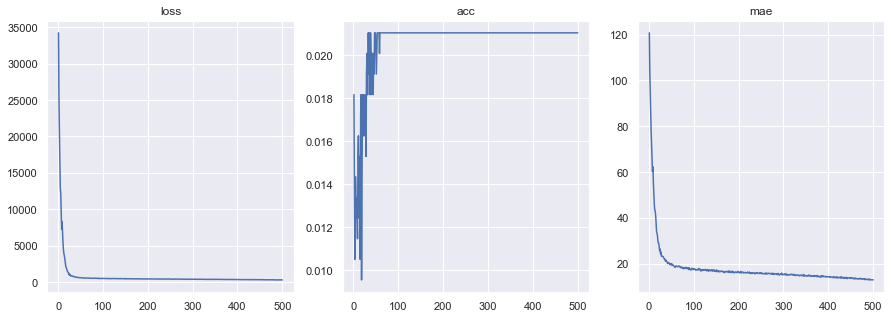

In [52]:
# Keras model
selected_features = ['PassengerId','Pclass', 'Sex#', 'SibSp', 'Parch', 'Fare']

x_train = df_data[df_data.Age.notnull()][selected_features]
y_train = df_data[df_data.Age.notnull()]['Age']
x_test = df_data[df_data.Age.isnull()][selected_features]

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(len(selected_features),))) # The number of features we use
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss='mse', optimizer='rmsprop', metrics=['acc', 'mae'])

history = model.fit(x_train[selected_features], y_train, batch_size=256, epochs=500, verbose=0)
model.evaluate(x_train[selected_features], y_train, batch_size=256, verbose=0)


loss = history.history['loss']
acc = history.history['acc']
mae = history.history['mae']

epochs = range(1, len(loss) + 1)

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5))
sns.lineplot(x=epochs, y=loss, palette='deep', ax=ax1)
sns.lineplot(x=epochs, y=acc, palette='deep', ax=ax2)
sns.lineplot(x=epochs, y=mae, palette='deep', ax=ax3)
ax1.title.set_text('loss')
ax2.title.set_text('acc')
ax3.title.set_text('mae')
plt.show()

In [53]:
df_data['Age_pred5'] = df_data['Age']
df_data.loc[df_data['Age'].isnull(), 'Age_pred5'] = model.predict(x_test[selected_features]).astype('int32')

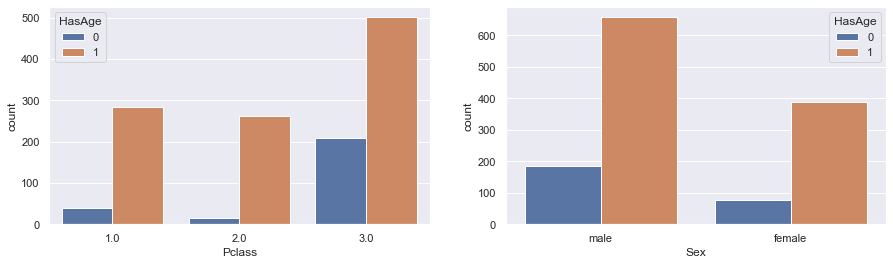

In [54]:
df_data['HasAge'] = df_data['Age'].notnull().map({True: 1, False: 0})
fig, [ax1, ax2] = plt.subplots(1, 2)

fig.set_figwidth(15)
sns.countplot(x=df_data['Pclass'], hue=df_data['HasAge'], ax=ax1)
sns.countplot(x=df_data['Sex'], hue=df_data['HasAge'], ax=ax2)
plt.show()
# From the left graph, we can know that most of the missing values are in Pclass = 3. 
# Therefore, if Age is an important feature, then our observation of Pclass = 3 might be incorrect. To avoid this, we can only observe age values in Pclass = 2 and 1. 
# The right graph shows higher age-missing rate for males than females.

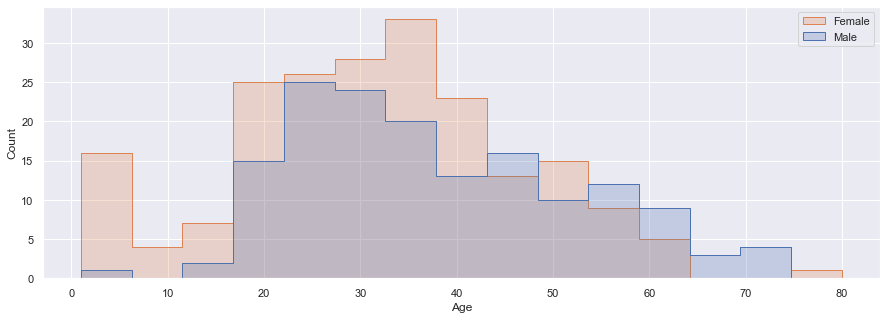

In [56]:
# Masks
Mask_Has_Age_P12 = df_data.loc[((df_data.HasAge == 1) & (df_data.Pclass != 3 ))]

fg, ax = plt.subplots(figsize=(15, 5))
ax = sns.histplot(Mask_Has_Age_P12, x='Age', hue='Survived', kde=False, bins=15, palette='deep', label='Survived', element='step')
ax.legend(['Survived', 'Unsurvived'])
plt.show()
# Low survival rate appears when Age < 16. When Age > 16, the distribution is not that distinct. 
# To conclude, we should find those missing values under 16 years old.

In [57]:
df_data['Minor_pred1'] = ((df_data['Age_pred1']) < 16)*1
df_data['Minor_pred2'] = ((df_data['Age_pred2']) < 16)*1
df_data['Minor_pred3'] = ((df_data['Age_pred3']) < 16)*1
df_data['Minor_pred4'] = ((df_data['Age_pred4']) < 16)*1
df_data['Minor_pred5'] = ((df_data['Age_pred5']) < 16)*1

In [58]:
# For the same reason as Fare, 
# we can use the same method to bucket the Age feature and check if this helps to improve the model.
df_data['AgeBin_pred1'] = pd.qcut(df_data['Age_pred1'], 5)
df_data['AgeBin_pred2'] = pd.qcut(df_data['Age_pred2'], 5)
df_data['AgeBin_pred3'] = pd.qcut(df_data['Age_pred3'], 5)
df_data['AgeBin_pred4'] = pd.qcut(df_data['Age_pred4'], 5)
df_data['AgeBin_pred5'] = pd.qcut(df_data['Age_pred5'], 5)

df_data['AgeBin_pred1'] = label_encoder.fit_transform(df_data['AgeBin_pred1'])
df_data['AgeBin_pred2'] = label_encoder.fit_transform(df_data['AgeBin_pred2'])
df_data['AgeBin_pred3'] = label_encoder.fit_transform(df_data['AgeBin_pred3'])
df_data['AgeBin_pred4'] = label_encoder.fit_transform(df_data['AgeBin_pred4'])
df_data['AgeBin_pred5'] = label_encoder.fit_transform(df_data['AgeBin_pred5'])

# Model Formulation

In [59]:
df_data[['PassengerId', 'Pclass', 'Sex#']] = df_data[['PassengerId', 'Pclass', 'Sex#']].astype('int32')
df_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex#,Fsize,IsAlone,FareBin,Fname,Connected_Survival,Embarked#,Title,Age_pred1,Age_pred2,Age_pred3,Age_pred4,Age_pred5,HasAge,Minor_pred1,Minor_pred2,Minor_pred3,Minor_pred4,Minor_pred5,AgeBin_pred1,AgeBin_pred2,AgeBin_pred3,AgeBin_pred4,AgeBin_pred5
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S,0,2,0,0,Braund,0.5,1,0,22,22.0,22.0,22.0,22.0,1,0,0,0,0,0,1,1,1,1,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,1,2,0,4,Cumings,0.5,2,4,38,38.0,38.0,38.0,38.0,1,0,0,0,0,0,3,3,3,3,3
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S,1,1,1,1,Heikkinen,0.5,1,3,26,26.0,26.0,26.0,26.0,1,0,0,0,0,0,2,1,2,2,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,1,2,0,4,Futrelle,0.0,1,4,35,35.0,35.0,35.0,35.0,1,0,0,0,0,0,3,3,3,3,3
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,S,0,1,1,1,Allen,0.5,1,0,35,35.0,35.0,35.0,35.0,1,0,0,0,0,0,3,3,3,3,3


In [60]:
# select features by correlation
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

In [62]:
cor_matrix = df_train.corr()
cor_matrix

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex#,Fsize,IsAlone,FareBin,Connected_Survival,Embarked#,Title,Age_pred1,Age_pred2,Age_pred3,Age_pred4,Age_pred5,HasAge,Minor_pred1,Minor_pred2,Minor_pred3,Minor_pred4,Minor_pred5,AgeBin_pred1,AgeBin_pred2,AgeBin_pred3,AgeBin_pred4,AgeBin_pred5
PassengerId,1.000000,-0.005007,-0.035144,0.036670,-0.057527,-0.001652,0.012658,-0.042939,-0.040143,0.057462,-0.006580,0.030376,-0.030444,-0.041261,0.038630,0.041145,0.039742,0.041260,0.034280,0.020167,-0.017941,-0.027431,-0.017941,-0.023668,-0.026113,0.047272,0.045777,0.048443,0.048862,0.032876
Survived,-0.005007,1.000000,-0.338481,-0.077628,-0.035322,0.081629,0.257307,0.543351,0.016639,-0.203367,0.317386,0.343614,0.111203,0.567132,-0.058824,-0.070994,-0.064240,-0.071503,-0.019424,0.092197,0.136107,0.136884,0.136107,0.140244,0.003761,0.008235,-0.020815,-0.041650,-0.032181,0.025186
Pclass,-0.035144,-0.338481,1.000000,-0.368659,0.083081,0.018443,-0.549500,-0.131900,0.065997,0.135207,-0.704620,-0.303375,0.040138,-0.139117,-0.417096,-0.355728,-0.410503,-0.339318,-0.373658,-0.172933,0.121920,0.131894,0.121920,0.115252,0.246324,-0.435977,-0.336501,-0.402981,-0.298566,-0.352047
Age,0.036670,-0.077628,-0.368659,1.000000,-0.308556,-0.189187,0.095659,-0.093646,-0.302147,0.198440,0.131161,0.063672,0.018433,-0.133162,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,-0.582554,-0.582554,-0.582554,-0.582554,-0.582554,0.901728,0.899377,0.915078,0.906198,0.929348
SibSp,-0.057527,-0.035322,0.083081,-0.308556,1.000000,0.414838,0.159651,0.114631,0.890712,-0.584471,0.356492,-0.205054,-0.061591,0.203240,-0.249795,-0.262029,-0.259530,-0.218361,-0.214982,-0.018958,0.352437,0.382516,0.352437,0.348727,0.243292,-0.204200,-0.208957,-0.244242,-0.155553,-0.208868
Parch,-0.001652,0.081629,0.018443,-0.189187,0.414838,1.000000,0.216225,0.245489,0.783111,-0.583398,0.347618,-0.020063,-0.080277,0.329165,-0.176553,-0.184439,-0.182892,-0.171283,-0.104298,0.124104,0.351481,0.360462,0.351481,0.347779,0.121031,-0.121870,-0.130646,-0.154031,-0.119450,-0.074899
Fare,0.012658,0.257307,-0.549500,0.095659,0.159651,0.216225,1.000000,0.182333,0.217138,-0.271832,0.602012,0.307091,0.065492,0.185714,0.123934,0.100258,0.115302,0.102274,0.132005,0.100707,0.003753,0.003423,0.003753,0.003988,-0.116381,0.137428,0.100535,0.109552,0.096178,0.138512
Sex#,-0.042939,0.543351,-0.131900,-0.093646,0.114631,0.245489,0.182333,1.000000,0.200988,-0.303646,0.244137,0.056500,0.121266,0.945510,-0.101391,-0.091923,-0.106080,-0.077086,-0.048167,0.055215,0.111141,0.097669,0.111141,0.107712,0.019637,-0.061377,-0.070062,-0.121159,-0.056349,-0.011633
Fsize,-0.040143,0.016639,0.065997,-0.302147,0.890712,0.783111,0.217138,0.200988,1.000000,-0.690922,0.417314,-0.150171,-0.082200,0.303353,-0.258929,-0.271231,-0.268750,-0.234812,-0.199038,0.049043,0.416472,0.441518,0.416472,0.412088,0.226747,-0.200448,-0.208083,-0.243882,-0.165990,-0.180172
IsAlone,0.057462,-0.203367,0.135207,0.198440,-0.584471,-0.583398,-0.271832,-0.303646,-0.690922,1.000000,-0.520586,-0.093428,0.020660,-0.414430,0.176546,0.177103,0.188355,0.168495,0.091194,-0.151319,-0.347400,-0.358790,-0.347400,-0.342421,-0.087633,0.108598,0.114189,0.163347,0.110018,0.045928


In [67]:
# find the corr with label
corr_mat_fil = cor_matrix.loc[:, 'Survived'].sort_values(ascending=False)
corr_mat_fil = pd.DataFrame(data=corr_mat_fil[1:])
corr_mat_fil

,Survived
Title,0.567132
Sex#,0.543351
Connected_Survival,0.343614
FareBin,0.317386
Fare,0.257307
Minor_pred4,0.140244
Minor_pred2,0.136884
Minor_pred1,0.136107
Minor_pred3,0.136107
Embarked#,0.111203


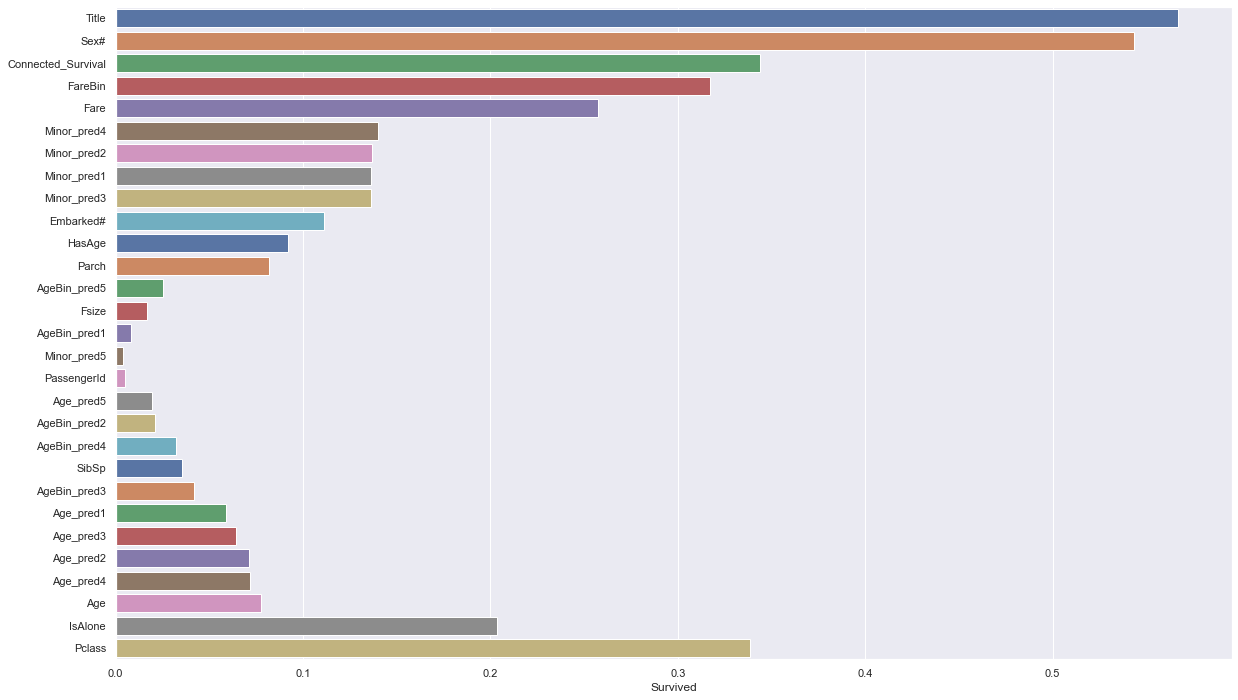

In [68]:
plt.figure(figsize=(20,12))
bar = sns.barplot(x=corr_mat_fil.Survived.abs(), y=corr_mat_fil.index, data=corr_mat_fil, palette='deep');

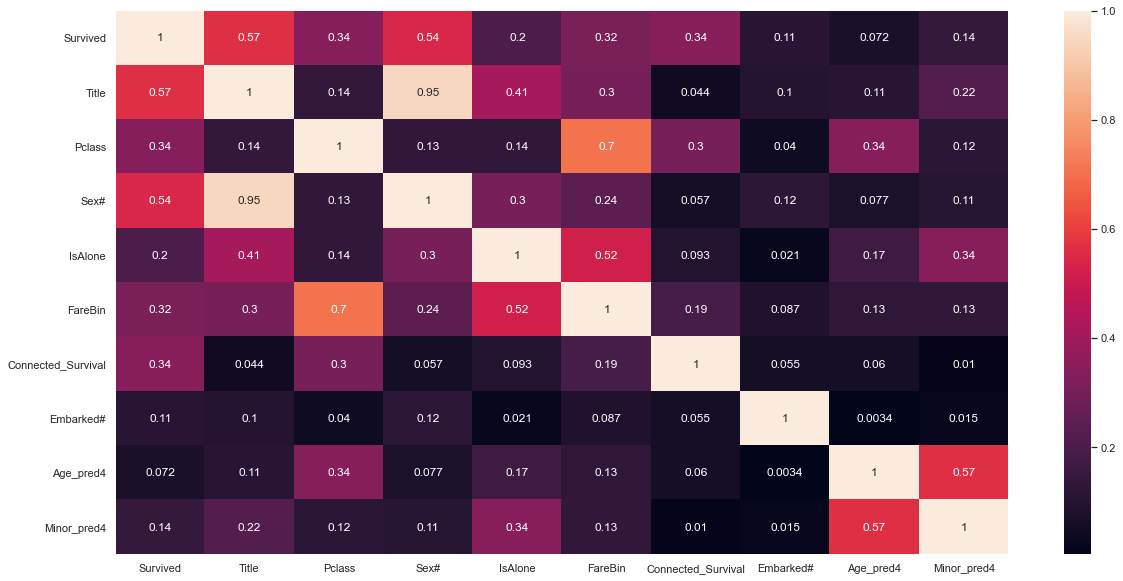

In [71]:
train_features = ['Survived', 'Title', 'Pclass', 'Sex#', 'IsAlone', 'FareBin', 'Connected_Survival', 'Embarked#', 'Age_pred4', 'Minor_pred4']
corr_mat = df_train[train_features].astype(float).corr()

plt.figure(figsize=(20,10))
sns.heatmap(corr_mat.abs(), annot=True)
plt.show()

In [76]:
selected_features = ['Sex#', 'Pclass', 'FareBin', 'Connected_Survival', 'Minor_pred2']
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

x_train = df_train[selected_features]
y_train = df_train['Survived']
x_test = df_test[selected_features]

In [77]:
model = RandomForestClassifier(random_state=2)

grid_parameters = {'n_estimators': [i for i in range(300, 601, 50)], 'min_samples_split' : [10, 20, 30, 40]}
grid = GridSearchCV(estimator=model, param_grid=grid_parameters)
grid_result = grid.fit(x_train, y_train)

# summarize results
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))

Best: 0.8439645973259683 using {'min_samples_split': 40, 'n_estimators': 300}


In [78]:
n_estimator = grid_result.best_params_['n_estimators']
min_samples_split = grid_result.best_params_['min_samples_split']

RFC = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20)
RFC.fit(x_train, y_train)
y_pred = RFC.predict(x_test)

output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_pred})
output = output.astype('int')
output.to_csv('RFC_prediction.csv', index=False)
print('Your file was successfully saved!')

Your file was successfully saved!
